# Understanding `kelp`

In this notebook, we try to understand the package `kelp` by playing around with some of its functionalities. We will try to find reflected phase curve and thermal phase curve for the WASP-189b planet, recently observed by CHEOPS. We first try to compute the thermal part.

### Total phase curve

A complete phase curves in `kelp`, which include the thermal emission as well as reflected light, are produced as descrribed by [Heng, Morris & Kitzmann (2021)](https://www.nature.com/articles/s41550-021-01444-7) and [Morris et al. (2021)](https://arxiv.org/abs/2110.11837), for reflected and thermal part, respectively. The individual parts are described later in the notebook.

It is known that a phase curve will be dependent on the planet and the filter in which it is being observed. Hence, before jumping into calculting the phase curves, we will create a `planet` object and a `filt` object for storing planetary and passband properties. One can directly take values of planetary parameters for various planets stored by default using `Planet.from_name` method. However, this does not contain all of the exoplanets, well, for obvious reasons. That's why we shall manually define the planetary properties. The same goes for filter, if a required filter is not available in `Filter.from_name` method, one can manually create one. Fortunately, the CHEOPS passband is available so, we will use it here.

We will use the planetary properties of WASP-189 from [Lendl et al. (2021)](https://doi.org/10.1051/0004-6361/202038677) and [Deline et al. (2022)](https://arxiv.org/abs/2201.04518).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from kelp import Planet, Filter, Model

In [2]:
# Needed planetary parameters
per=2.7240330
t0=2458926.5416960
inc=84.03
rp=0.069577
ecc=0.
a=4.60
u=[0.414, 0.155]
fp=9.65e-5
t_secondary=2458927.9037125
T_s=8000.
rp_a=0.015168

In [3]:
## Creating a Planet Object
plan = Planet(per=per,\
     t0=t0,\
     inc=inc,\
     rp=rp,\
     ecc=ecc,\
     w=None,\
     a=a,\
     u=u,\
     fp=fp,\
     t_secondary=t_secondary,\
     T_s=T_s,\
     rp_a=rp_a, limb_dark='quadratic', name='WASP-189')

fltr = Filter.from_name('CHEOPS')

In [4]:
cml = [[0.],[0., 0.18, 0.]]
# Defining the model
model = Model(hotspot_offset=-0.12043, alpha=0.6, A_B=0., omega_drag=4.5, C_ml=cml, lmax=1, planet=plan, filt=fltr)

The total phase curve would be,

Text(0, 0.5, 'Fp/F* (in ppm)')

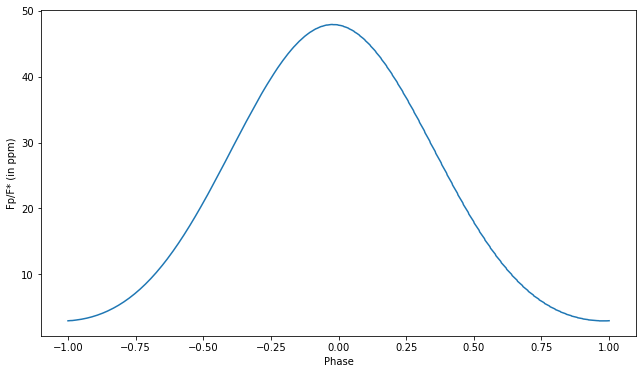

In [9]:
# Phases of the orbit, 0. corresponds to the eclipse, while -1. and 1. to the transits
xi = np.linspace(-np.pi, np.pi, 1000)
ome1 = 0.
g1 = 0.
pc_tot, ag_tot, q_tot = model.phase_curve(xi=xi, omega=ome1, g=g1)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, pc_tot.flux)
plt.xlabel('Phase')
plt.ylabel('Fp/F* (in ppm)')

On the top of this, we can add an eclipse model from `batman`.

(1.00002, 1.00016)

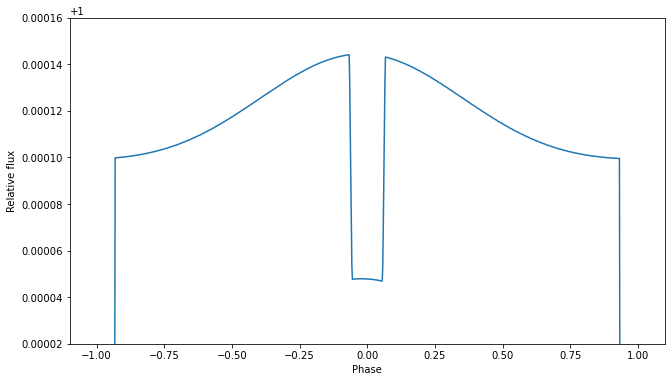

In [21]:
pars = batman.TransitParams()
pars.t0 = -np.pi
pars.per = 2.#per
pars.rp = rp
pars.a = a
pars.inc = inc
pars.ecc = ecc
pars.w = 90.
pars.limb_dark = 'quadratic'
pars.u = u
pars.fp = fp
pars.t_secondary = 0.

m1 = batman.TransitModel(pars, xi/np.pi, transittype='secondary')
m2 = batman.TransitModel(pars, xi/np.pi)
flx_ecl = m1.light_curve(pars)
flx_tra = m2.light_curve(pars)

flx_both = flx_ecl*flx_tra

tot_flx = flx_ecl*pc_tot.flux/1e6
plt.figure(figsize=(16/1.5, 9/1.5))
plt.plot(xi/np.pi, flx_both + (pc_tot.flux/1e6))
plt.xlabel('Phase')
plt.ylabel('Relative flux')
plt.ylim([1.00002, 1.00016])

### Thermal phase curve

We can first generate a temperature map from this model.

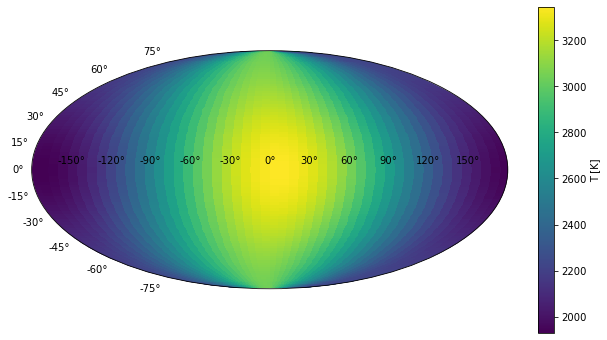

In [22]:
T, theta, phi = model.temperature_map(100, 100, f=2**-0.5)

# Plot the temperature map
fig = plt.figure(figsize=(16/1.5,9/1.5))
ax = fig.add_subplot(111, projection='mollweide')
cax = ax.pcolormesh(phi, theta - np.pi/2, T, shading='auto')
plt.colorbar(cax, label='T [K]')
plt.show()

And, using the above temperature map, one can produce the 